<a href="https://colab.research.google.com/github/vineet35R/TEXT-TO-SPEECH/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


In [ ]:
#set display option for rows & columns
pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [ ]:

import pandas as pd
import numpy as np

# Load training dataset
train_df = pd.read_csv("train_transaction.csv")
print("Train Data Shape:", train_df.shape)

# Load test dataset
test_df = pd.read_csv("test_transaction.csv")
print("Test Data Shape:", test_df.shape)

Train Data Shape: (43308, 394)
Test Data Shape: (41866, 393)


In [ ]:
# Removing highly co-related D and C features
# D features
D_features_train_df = train_df[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']]
cor = D_features_train_df.corr()
cor

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.986113,0.279397,0.635296,0.048720,0.588512,0.194968,0.001424,-0.015554,0.608595,0.603766,0.572264,0.322949,0.182869,0.672309
D2,0.986113,1.000000,0.263569,0.612507,0.230421,0.680654,0.482252,0.238753,-0.012209,0.570210,0.574569,0.687317,0.363858,0.246462,0.643728
D3,0.279397,0.263569,1.000000,0.152722,0.766023,0.375359,0.827069,0.134842,0.017377,0.107929,0.043992,0.395719,0.133529,0.101644,0.140981
D4,0.635296,0.612507,0.152722,1.000000,0.274736,0.948250,0.559005,0.067772,0.047025,0.675439,0.694290,1.000000,0.372458,0.191417,0.780233
D5,0.048720,0.230421,0.766023,0.274736,1.000000,0.540407,0.996121,0.205481,0.030848,0.077787,0.038571,0.553654,0.170839,0.066199,0.165255
D6,0.588512,0.680654,0.375359,0.948250,0.540407,1.000000,0.525277,0.172888,0.038953,0.429258,NaN,0.967400,0.363289,0.185077,0.733263
D7,0.194968,0.482252,0.827069,0.559005,0.996121,0.525277,1.000000,0.212513,0.029822,0.255485,NaN,0.535734,0.164645,0.040977,0.325061
D8,0.001424,0.238753,0.134842,0.067772,0.205481,0.172888,0.212513,1.000000,0.067377,0.182862,NaN,0.117049,0.544730,0.078300,0.148163
D9,-0.015554,-0.012209,0.017377,0.047025,0.030848,0.038953,0.029822,0.067377,1.000000,0.070737,NaN,0.054083,0.016249,-0.024683,0.043208
D10,0.608595,0.570210,0.107929,0.675439,0.077787,0.429258,0.255485,0.182862,0.070737,1.000000,0.633780,0.008616,0.277080,0.346710,0.744239


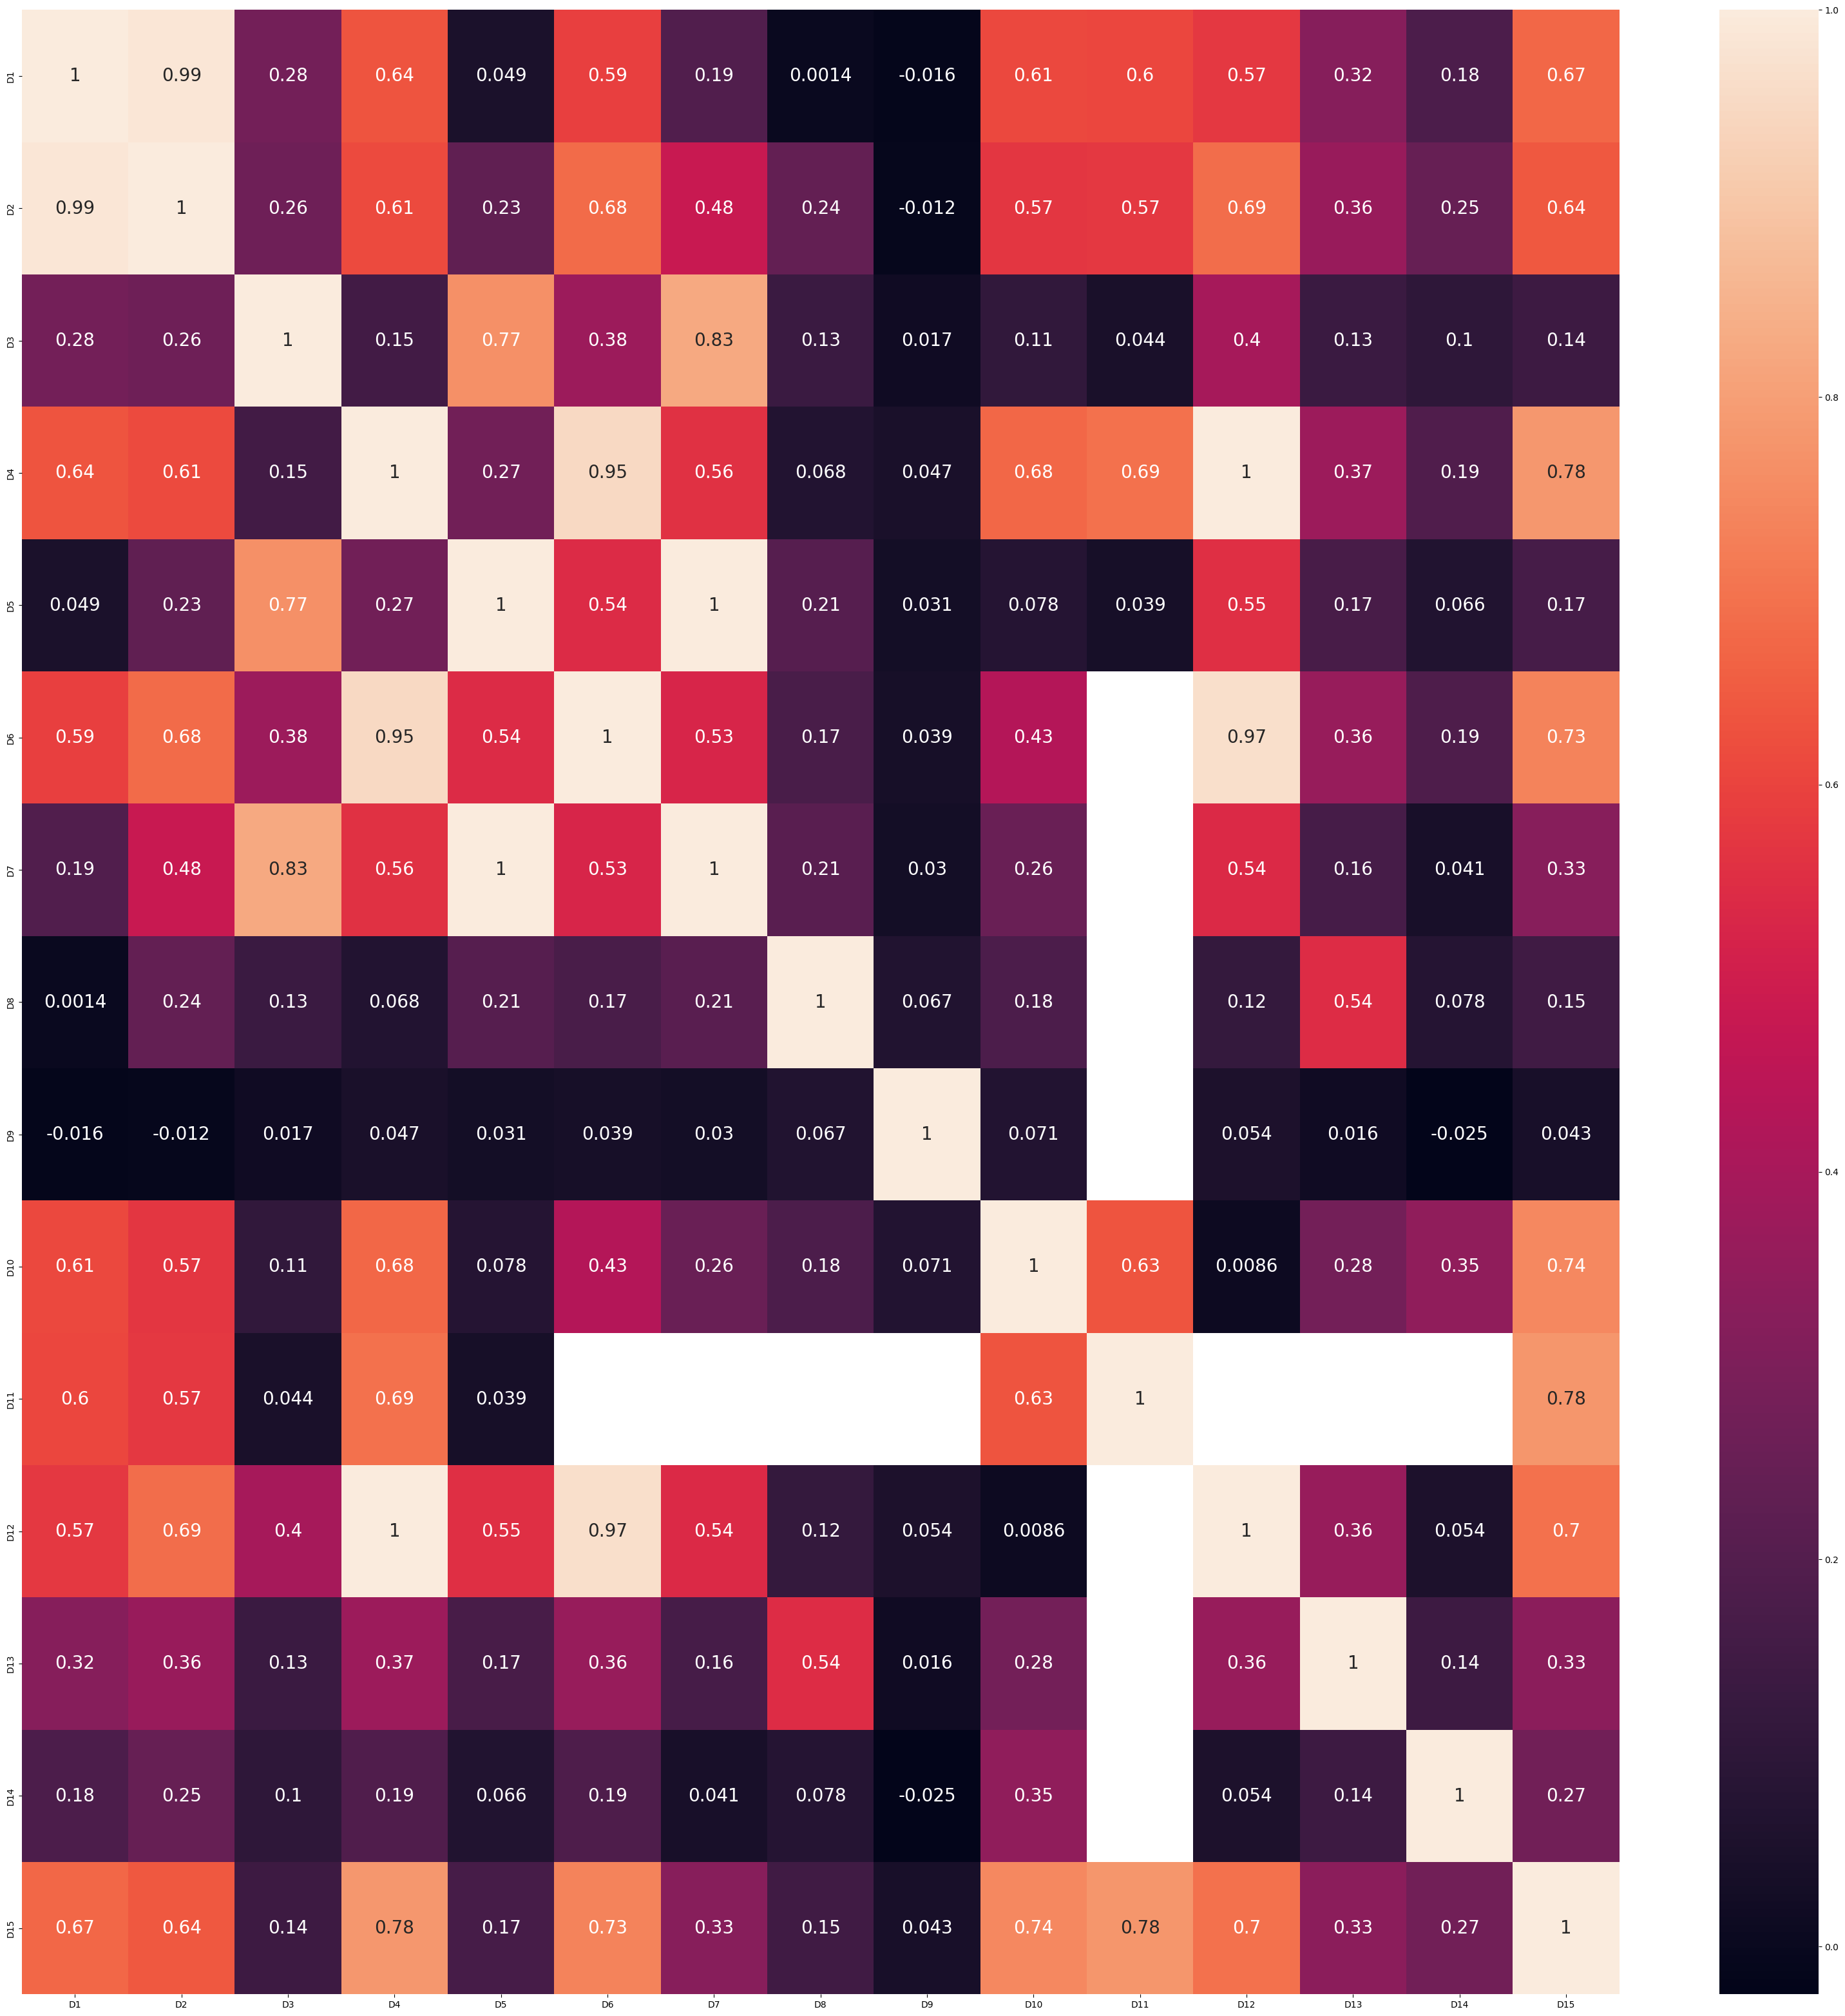

In [ ]:
plt.figure(figsize = (40,40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [ ]:
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['D2', 'D7', 'D12']

In [ ]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
# C features
C_features_train_df = train_df[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]
cor = C_features_train_df.corr()
cor

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.989310,-0.015527,0.973719,0.170582,0.992609,0.954484,0.971049,0.179856,0.969422,0.998852,0.954978,0.827236,0.966678
C2,0.989310,1.000000,-0.014575,0.973453,0.101837,0.971667,0.965793,0.975340,0.105297,0.979590,0.989705,0.970058,0.786560,0.931691
C3,-0.015527,-0.014575,1.000000,-0.009722,-0.020976,-0.017817,-0.010560,-0.009647,-0.025853,-0.010089,-0.015151,-0.010733,-0.026017,-0.019151
C4,0.973719,0.973453,-0.009722,1.000000,-0.023889,0.960153,0.960990,0.987395,-0.029442,0.981977,0.976430,0.960306,0.699253,0.902565
C5,0.170582,0.101837,-0.020976,-0.023889,1.000000,0.227328,-0.022308,-0.023394,0.917717,-0.023705,0.160426,-0.022653,0.663855,0.380218
C6,0.992609,0.971667,-0.017817,0.960153,0.227328,1.000000,0.921409,0.947261,0.243739,0.941696,0.993659,0.920654,0.850800,0.983092
C7,0.954484,0.965793,-0.010560,0.960990,-0.022308,0.921409,1.000000,0.991585,-0.027495,0.994814,0.955100,0.999339,0.699138,0.862940
C8,0.971049,0.975340,-0.009647,0.987395,-0.023394,0.947261,0.991585,1.000000,-0.028832,0.998138,0.972939,0.990382,0.705387,0.889262
C9,0.179856,0.105297,-0.025853,-0.029442,0.917717,0.243739,-0.027495,-0.028832,1.000000,-0.029216,0.171327,-0.027882,0.645473,0.398264
C10,0.969422,0.979590,-0.010089,0.981977,-0.023705,0.941696,0.994814,0.998138,-0.029216,1.000000,0.970670,0.994940,0.706430,0.882786


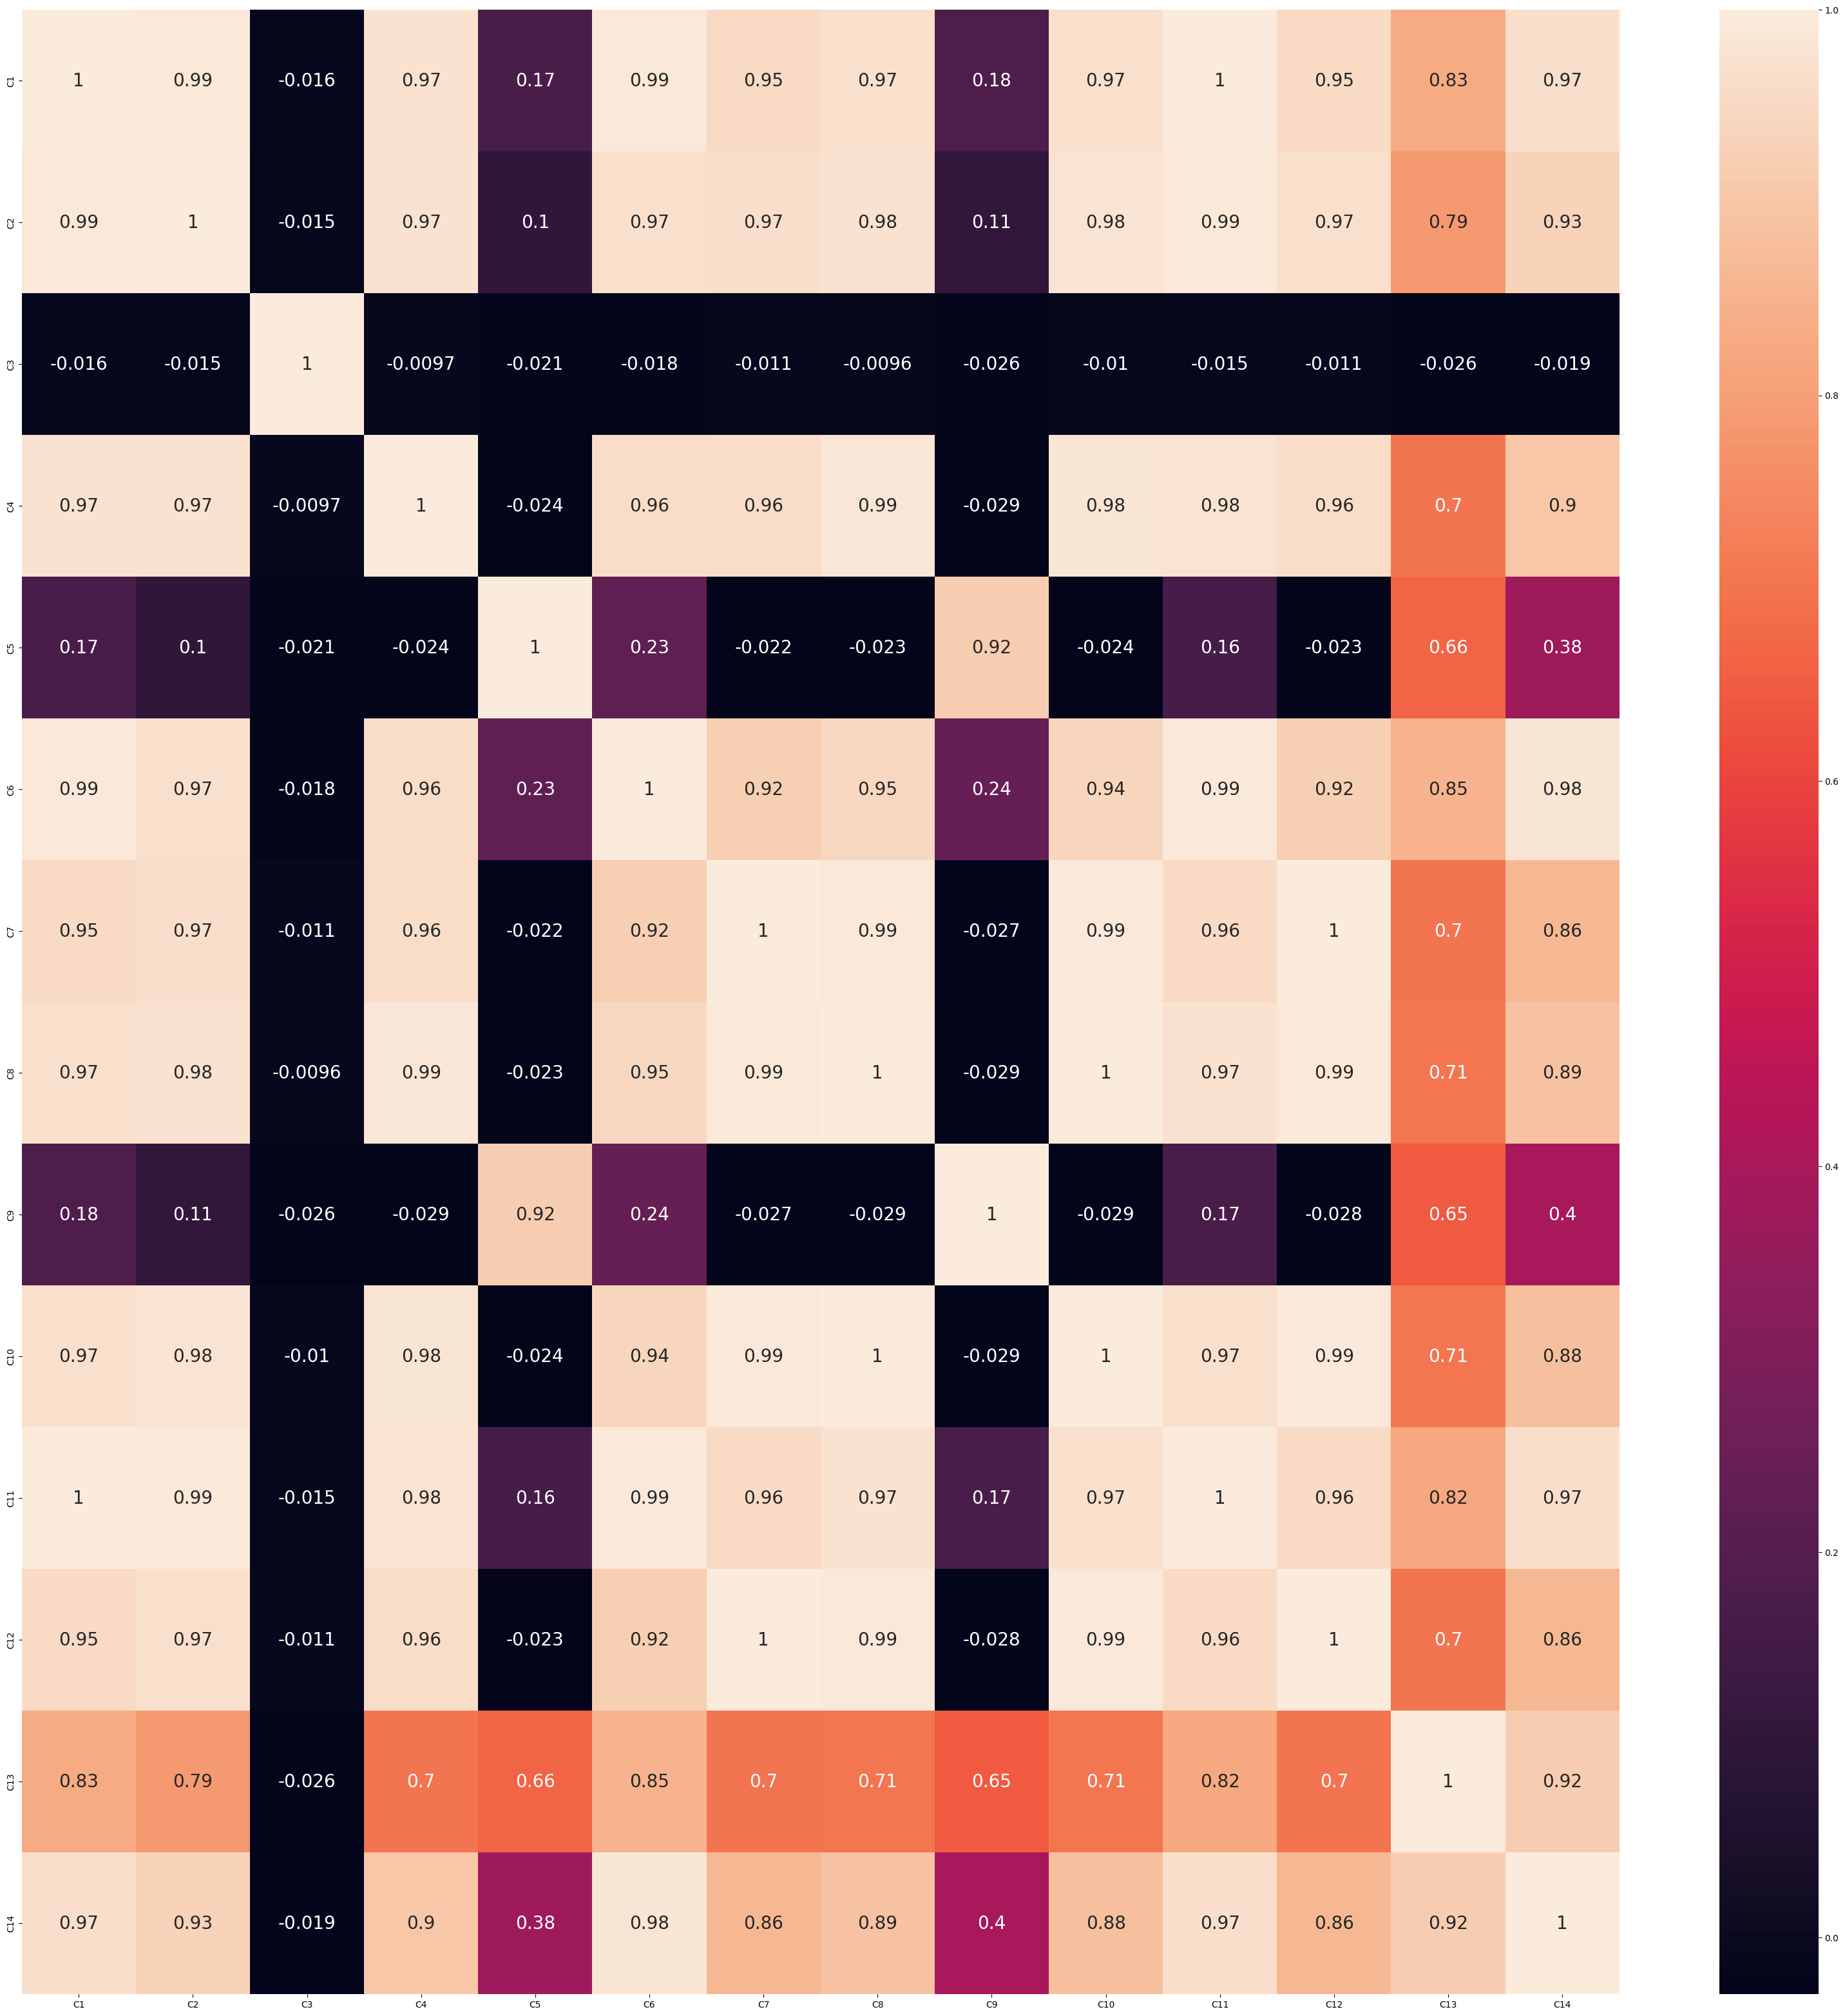

In [ ]:
plt.figure(figsize = (40, 40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [ ]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1 ).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C14']

In [ ]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
del D_features_train_df, C_features_train_df
train_df.columns.to_list()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C3',
 'C5',
 'C9',
 'C13',
 'D1',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V7

**Removing infinity values**

In [ ]:
# any infitinte value in dataset
train_df.isin([np.inf, -np.inf]).sum().any()

False

In [ ]:
# There are few infinity values
df = train_df.isin([np.inf, -np.inf]).sum()[-2:]
print(df)

V338    0
V339    0
dtype: int64


In [ ]:
del df

**Data Imputation**

In [ ]:
# lets convert this inf value to NaN then impute using the mean

train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
test_df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [ ]:
# impute numerical value by median for each feature

for i in train_df.columns:
    if train_df[i].dtypes == 'int64' or train_df[i].dtypes == 'int32' or train_df[i].dtypes == 'int16' or train_df[i].dtypes == 'int8' or train_df[i].dtypes == 'float64' or train_df[i].dtypes == 'float32' or train_df[i].dtypes == 'float16' :
        train_df[i].fillna(train_df[i].median(), inplace = True )


In [ ]:
# imputation of categorical features by mode

for i in train_df.columns:
    if train_df[i].dtypes == 'object':
        train_df[i].fillna(train_df[i].mode()[0], inplace = True)

In [ ]:
train_df.isnull().sum().any()

False

In [ ]:
# imputation of numerical features with median

for i in test_df.columns:

    if test_df[i].dtypes == 'int64' or test_df[i].dtypes == 'int32' or test_df[i].dtypes == 'int16' or test_df[i].dtypes == 'int8' or test_df[i].dtypes == 'float64' or test_df[i].dtypes == 'float32' or test_df[i].dtypes == 'float16' :
        test_df[i].fillna(test_df[i].median(), inplace = True)


In [ ]:
# imputation of categorical features by mode

for i in test_df.columns:
    if test_df[i].dtypes == 'object':
        test_df[i].fillna(test_df[i].mode()[0], inplace = True)


In [ ]:
test_df.isnull().sum().any()

False

In [ ]:
# encoding categorical feature before model training using label encoder
from sklearn.preprocessing import LabelEncoder

for i in train_df.columns:
  if train_df[i].dtypes == "object":
    le = LabelEncoder()
    train_df[i] = le.fit_transform(train_df[i].astype(str).values)

In [ ]:
#encoding test data using laber encoder

for i in test_df.columns:
  if test_df[i].dtypes == "object":
    le = LabelEncoder()
    test_df[i] = le.fit_transform(test_df[i].astype(str).values)

**Train Test split**

In [ ]:
train_df = train_df.sample(frac = .7)

In [ ]:
#Train test split

train_data = train_df[:int(train_df.shape[0]*0.70)]
cv_data = train_df[int(train_df.shape[0]*0.70):]
#X-y split

x_train = train_data.drop(['isFraud'], axis = 1)
y_train = train_data['isFraud']
x_cv = cv_data.drop(['isFraud'], axis = 1)
y_cv = cv_data['isFraud']

**Feature Scaling**

In [ ]:
#standardizing the train and cv x for logistic regression model

sc = StandardScaler()
sc_x_train = sc.fit_transform(x_train)
sc_x_cv = sc.transform(x_cv)

**ML Models**

***Logistic Regression***

In [ ]:
#traing model with default values

# Training the model with the correct loss function
clf = SGDClassifier(loss="log_loss")  # ✅ Corrected from "log" to "log_loss"
clf.fit(sc_x_train, np.array(y_train).ravel())  # Ensure y_train is 1D

# Predictions
y_trainpred = clf.predict_proba(sc_x_train)
y_cvpred = clf.predict_proba(sc_x_cv)

In [ ]:
print('Train AUC is :', roc_auc_score(y_train, y_trainpred[:,1]))
print('CV AUC :', roc_auc_score(y_cv, y_cvpred[:,1]))

Train AUC is : 0.8412629866411171
CV AUC : 0.8353882050457131
